In [1]:
#Import Dependencies and Formatting
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import DateFormatter
style.use('fivethirtyeight')
%matplotlib inline

# Reflect Tables into SQLAlchemy ORM

In [2]:
#Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
#Declare a Base using automap_base()
Base = automap_base()

#Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
#Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [6]:
#Assign the measurement class to a variable called 'measurement'
measurement = Base.classes.measurement

#Assign the station class to a variable called 'station'
station = Base.classes.station

In [7]:
#Create the session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [8]:
#Use the inspector to see the columns of the measurement object
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Use the inspector to see the columns of the station object
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate the date 1 year before the last data point in the database
date_query = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date_str = date_query[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d')
    #https://stackoverflow.com/questions/466345/converting-string-into-datetime
year_ago = last_date - dt.timedelta(days=365)
print(f'This shows the percipitation data between {year_ago} and {last_date}.')

#Perform a query to retrieve the data and precipitation scores
precip_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago)

#Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_query, columns = ['Date', 'Precipitation'])
precip_df = precip_df.set_index('Date')

#Sort the dataframe by date
precip_df = precip_df.sort_values('Date')

#Print the dataframe
precip_df

This shows the percipitation data between 2016-08-23 00:00:00 and 2017-08-23 00:00:00.


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


Text(0, 0.5, 'Precipitation (in)')

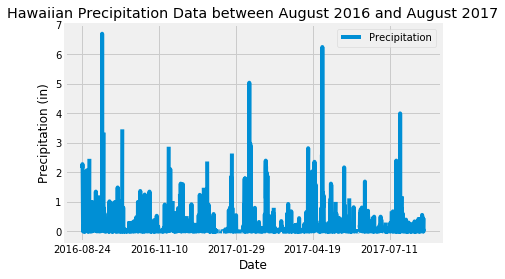

In [11]:
#Use Pandas Plotting with Matplotlib to plot the precipitation data

#Create the bar chart from the precip_df dataframe
precip_df.plot()

#Format the bar chart
plt.title('Hawaiian Precipitation Data between August 2016 and August 2017')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

In [12]:
#Use Pandas and Numpy to calcualte the summary statistics for the precipitation data
precip_mean = precip_df['Precipitation'].mean()
precip_median = precip_df['Precipitation'].median()
precip_variance = precip_df['Precipitation'].var()
precip_std = precip_df['Precipitation'].std()
precip_sem = precip_df['Precipitation'].sem()

#Combine the statistical values into a summary table
summary_statistics = pd.DataFrame([precip_mean, precip_median, precip_variance, precip_std, precip_sem],['Mean', 'Median', 'Variance', 'Standard Deviation', 'Standard Error of the Mean'], columns = ['Value'])

#Print summary statistics table
summary_statistics

,Value
Mean,0.176462
Median,0.020000
Variance,0.211865
Standard Deviation,0.460288
Standard Error of the Mean,0.010254


### Station Analysis

In [13]:
#Design a query to show how many stations are available in this dataset.
unique_stations_number = session.query(measurement.station).distinct().count()
    #or unique_stations_number = engine.execute('select distinct(station) from measurement').fetchall()
    #https://stackoverflow.com/questions/17223174/returning-distinct-rows-in-sqlalchemy-with-sqlite

#Print the result
print(f'There are {unique_stations_number} unique stations in the Measurements dataset.')

There are 9 unique stations in the Measurements dataset.


In [14]:
#What are the most active stations?(i.e. what stations have the most rows)?

#Design a query to list the stations and the counts in descending order.
unique_stations_list = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
    #https://docs.sqlalchemy.org/en/13/orm/query.html
    #or unique_stations_list = engine.execute('Select station, count(station) from measurement Group by station Order by count(station) desc').fetchall()

#Pull the query result into a dataframe
active_stations_df = pd.DataFrame(unique_stations_list, columns = ['Station', 'Count'])

#Print the resulting dataframe
active_stations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
#Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station.

#Obtain the station id of the most active station
most_active_station = active_stations_df.iloc[0,0]
print(f'The most active station is {most_active_station}.')

#Find the lowest recorded temperature at the most active station
lowest_temperature = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station).scalar()
    #https://docs.sqlalchemy.org/en/13/orm/query.html
print(f'The lowest temperature recorded at Station {most_active_station} is {lowest_temperature}.')

#Find the highest recorded temperature at the most active station
highest_temperature = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station).scalar()
print(f'The highest temperature recorded at Station {most_active_station} is {highest_temperature}.')

#Find the highest recorded temperature at the most active station
average_temperature = round(session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station).scalar(),2)
print(f'The average temperature recorded at Station {most_active_station} is {average_temperature}.')

The most active station is USC00519281.
The lowest temperature recorded at Station USC00519281 is 54.0.
The highest temperature recorded at Station USC00519281 is 85.0.
The average temperature recorded at Station USC00519281 is 71.66.


In [19]:
#Choose the station with the highest number of temperature observations. Query the last 12 months of temperature observation data for this station and plot the results as a histogram.

#Obtain the station id of the most active station.
print(f'The most active station is {most_active_station}.')

#Perform a query to retrieve the temperature data for the most active station in the previous year
most_active_temp_query = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station).filter(measurement.date >= year_ago).filter(measurement.date <= last_date)

#Save the query results as a Pandas DataFrame and set the index to the date column
most_active_temp_df = pd.DataFrame(most_active_temp_query, columns = ['Date', 'Temperature'])
most_active_temp_df = most_active_temp_df.set_index('Date')

#Print the resulting dataframe
most_active_temp_df

The most active station is USC00519281.


,Temperature
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


Text(0, 0.5, 'Observations')

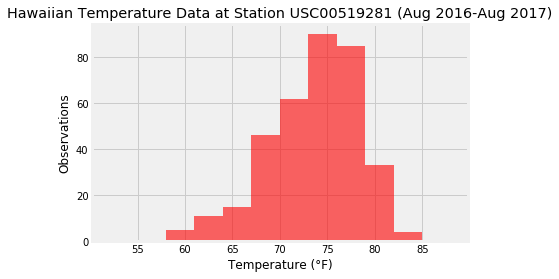

In [20]:
#Use the most_active_temp_df dataframe to create a histogram modelling the data.
most_active_temp_df['Temperature'].plot.hist(bins = [52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88], color="red", alpha=0.6)

#Format the histogram
plt.title(f'Hawaiian Temperature Data at Station {most_active_station} (Aug 2016-Aug 2017)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Observations')